#Brutus 

bsub -n 80 /cluster/home03/math/echeverl/local/bin/ipcluster start --n=80 --engines=MPI --profile=default

ipcontroller2 --profile=default &

#Euler

%%bash

bsub -n 40 /cluster/home/echeverl/python/bin/ipcluster engines --n=40 --engines=MPI --profile=mpi & 

/cluster/home/echeverl/python/bin/ipcontroller --profile=mpi &

In [2]:
import os
from IPython import parallel
#engines = parallel.Client(profile="default")
#engines = parallel.Client(profile="nbserver")
engines = parallel.Client(profile="mpi")
dview = engines[:]
dview.block = True
dview.scatter('id',engines.ids, flatten=True) #common for using data instead of getting the list 

print('Processes Running:', len(engines))
for view in engines:
    print('Process ID:',view['id'],'PID',view.apply_sync(os.getpid))

IOError: Connection file u'~/.ipython/profile_mpi/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [2]:
%%px
import os
os.chdir('/cluster/home03/math/echeverl/PopulationDynamics')
#print(os.getcwd())

In [3]:
%%px
# MPI initialization, library imports and sanity checks on all engines
from mpi4py import MPI
# Load data publication API so engines can send data to notebook client
# Leo: publishing the array itself, not a representation of object but the object
#from IPython.kernel.zmq.datapub import publish_data  
import numpy as np
import time

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print("MPI rank: %i/%i" % (mpi.rank,mpi.size))

CompositeError: one or more exceptions from call to method: execute
[0:execute]: ImportError: libmpi.so.0: cannot open shared object file: No such file or directory
[1:execute]: ImportError: libmpi.so.0: cannot open shared object file: No such file or directory
[2:execute]: ImportError: libmpi.so.0: cannot open shared object file: No such file or directory
[3:execute]: ImportError: libmpi.so.0: cannot open shared object file: No such file or directory
.... 6 more exceptions ...

In [72]:
%%px
#% matplotlib inline
#from strategyTravelingWavesv1 import Simulation
#from strategyTravelingWavesv1 import *
from Simulation import *

In [73]:
%%px
def step1X(rowsLoc):
    locX = 0
    rowIn = 0 
    for row in rowsLoc:
        nSegs = nxsegs[rowIn] #Number of segments
        rowIn = rowIn+1
        for k in range(0,nSegs):
            colStart=xstart_seg[locX+k] #From: segment starts
            colEnd=xend_seg[locX+k] #To:segmend ends
            nInSeg=colEnd-colStart+1 #Number of inner segments

            u1[1:nInSeg+1] = u[row,colStart:colEnd+1]

            #Dirichlet B.C.
            u1[0] = 0 # water cells 
            u1[nInSeg+1] = 0 #Water cells

            #Neumann B.C 
            #u1[0] = u1[1]
            #u1[nInSeg+1] = u1[nInSeg]


            #ut = godunovstep1(ninseg+2,h,kcfl,u1,sc1,sc2)
            #Booster Subroutine
            ut = modules.godunovstep1(h,kcfl,u1[0:nInSeg+2])
            u[row,colStart:colEnd+1] = ut[1:nInSeg+1]

        locX = locX + nSegs #Number of scanned segments

def stepY(colsLoc):    
    locY = 0
    colIn = 0 
    for col in colsLoc:
        nSegs = nysegs[colIn]
        colIn = colIn + 1 
        for k in range(0,nSegs):
            rowStart=ystart_seg[locY+k]
            rowEnd=yend_seg[locY+k]
            nInSeg=rowEnd-rowStart+1

            #print('u0:', u0[1:nInSeg+1].shape) # (2,), (26,), (2,))
            #print('u:',u[rowStart:rowEnd+1,col].shape) # (0,), (0,), (0,))
            u0[1:nInSeg+1] = u[rowStart:rowEnd+1,col]
            kap0[1:nInSeg+1] = w_L[rowStart:rowEnd+1,col]*(1-wt0) + w_H[rowStart:rowEnd+1,col]*wt0
            kaph[1:nInSeg+1] = w_L[rowStart:rowEnd+1,col]*(1-wth) + w_H[rowStart:rowEnd+1,col]*wth

            kap0[0] = 1 #??
            kap0[nInSeg+1] = 1 #??
            kaph[0] = 1  #??
            kaph[nInSeg+1] = 1 ##??

            #Dirichlet B.C.
            u0[0] = 0 
            u0[nInSeg+1] = 0

            #Neumann B.C 
            #u0[0] = u0[1]
            #u0[nInSeg+1] = u0[nInSeg]

            #ut = godunovstep2(ninseg+2,h,kcfl,u0,sc1,sc2,kap0,kaph)
            #Booster Subroutine
            ut = modules.godunovstep2(h,kcfl,u0[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])

            u[rowStart:rowEnd+1,col] = ut[1:nInSeg+1]

        locY = locY + nSegs
        
def step1Y(colsLoc):        
    locY = 0
    colIn = 0 
    for col in colsLoc:
        nSegs = nysegs[colIn] #Number of segments 
        colIn = colIn + 1
        for k in range(0,nSegs):
            rowStart=ystart_seg[locY+k] #From: segment starts
            rowEnd=yend_seg[locY+k] #To:segmend ends
            nInSeg=rowEnd-rowStart+1

            u0[1:nInSeg+1] = u[rowStart:rowEnd+1,col]

            #Dirichlet b.c.
            u0[0] = 0
            u0[nInSeg+1] = 0
            #Neumann B.C 
            #u0[0] = u0[1]
            #u0[nInSeg+1] = u0[nInSeg]

            #ut = godunovstep1(ninseg+2,h,kcfl,u0,sc1,sc2)
            #Booster Subroutine
            ut = modules.godunovstep1(h,kcfl,u0[0:nInSeg+2])
            u[rowStart:rowEnd+1,col] = ut[1:nInSeg+1]

        locY = locY + nSegs

def stepX(rowsLoc):
    locX = 0
    rowIn = 0 
    for row in rowsLoc:
        nSegs = nxsegs[rowIn]
        rowIn = rowIn + 1
        for k in range(0,nSegs):
            colStart=xstart_seg[locX+k]
            colEnd=xend_seg[locX+k]
            nInSeg=colEnd-colStart+1

            kap0[0] = 1 
            kap0[nInSeg+1] = 1
            kaph[0] = 1
            kaph[nInSeg+1] = 1

            u1[1:nInSeg+1] = u[row,colStart:colEnd+1]
            kap0[1:nInSeg+1] = w_L[row,colStart:colEnd+1]*(1-wt0) + w_H[row,colStart:colEnd+1]*wt0
            #No interpolation
            #kap0[1:ninseg+1] = w_L[i,jstart:jend+1]
            kaph[1:nInSeg+1] = w_L[row,colStart:colEnd+1]*(1-wth) + w_H[row,colStart:colEnd+1]*wth
            #No interpolation
            #kaph[1:ninseg+1] = w_L[i,jstart:jend+1]

            #Dirichlet b.c.
            u1[0] = 0 
            u1[nInSeg+1] = 0
            #Neumann B.C 
            #u1[0] = u1[1]
            #u1[nInSeg+1] = u1[nInSeg]


            #ut = godunovstep2(ninseg+2,h,kcfl,u1,sc1,sc2,kap0,kaph)
            #Fortran Subroutine
            ut = modules.godunovstep2(h,kcfl,u1[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])
            u[row,colStart:colEnd+1] = ut[1:nInSeg+1]


        locX = locX + nSegs

def plotting(u_plot):
    from  matplotlib import pyplot 
    import matplotlib.cm as cm
    print("=====Plotting Results=====")
    fig = pyplot.figure(figsize=(5,5))
    pyplot.subplot(111)
    pyplot.title('Data')
    im = pyplot.imshow(u_plot, cmap = cm.RdBu_r)
    cb = pyplot.colorbar()


#BroadCasting Data

In [74]:
%%px
%%time
sim = LargeSimulation()
#sim = HugeSimulation()
print("====="+sim.data.mapsize+" Simulation Starting=====")
output = False
module = 'C'

#Deciding which booster to use 
if module == 'Fortran':
    import Fmodules as modules

elif module =='C':
    import Cmodules as modules

elif module =='Python':
    import Pymodules as modules 

Ts = sim.data.Ts
Te = sim.data.Te
tsc = sim.data.tsc
h = sim.data.h
kcfl = sim.data.kcfl
u = sim.data.u      

NS = max(sim.data.NY,sim.data.NX) #find max size 
u0 = zeros(NS)         
u1 = zeros(NS) 
kap0 = zeros(NS)
kaph = zeros(NS)

rows = arange(sim.data.NY)
cols = arange(sim.data.NX)
#Local Rows
#dRow = int(sim.data.NY/mpi.size)
#rowLoc = range(mpi.rank*dRow, (mpi.rank+1)*dRow)
rowCat = split(rows,mpi.size)
rowLoc = rowCat[mpi.rank]
#Local Cols
#dCol = int(sim.data.NX/mpi.size)
#colLoc = range(mpi.rank*dCol, (mpi.rank+1)*dCol)
colCat = split(cols,mpi.size)
colLoc = colCat[mpi.rank]

yp = yppoints() #Interpolation points   

# read the CC map lists and times=tepoch's for each frame: find first
# Search for appropriate NPP maps:
#      from start time Ts (in kya) to end time Te
#loading carrying capacities from namelist
yalist, masks, tepoch = get_cc_list(sim.data.mapsize)

#kstart = 1  
kstart = 0
while tepoch[kstart+1] >= Ts:
    kstart=kstart+1

print('   Start time Ts=%5.1f (kya), NPP frame kstart=%d\n'%(Ts,kstart))

kend = 61 #Leo: Verify this, it's probably 60
while tepoch[kend-1] <= Te: 
    kend=kend-1

print('   End time   Te=%5.1f (kya), NPP frame kend=%d\n'%(Te,kend))

# make sure there are at least 2 maps between Ts and Te
if ((kend-kstart)<1) or ((tepoch[kstart]-tepoch[kend])<(Ts-Te)):
   print('Ts=%e, Te=%e, not space enough: kstart=%d, kend=%d\n'%(Ts,Te,kstart,kend))

#      start and end maps found
kmp = kstart # start counting maps here

#Using Jed's map
#if self.data.mapsize =='big':
#    import netCDF4
#    data = netCDF4.Dataset('/Users/Leo/Desktop/Maps_Leo/fep_test.nc','r')
#    w_J = flipud(data.variables['FEP'][:].data)
#    w_J = roll(w_J,-310,axis=1)
#    w_J[w_J<0]=0
#    w_L = w_J.copy()
#    w_H = w_J.copy()
#    t_L = tepoch[kmp]
#    kmp = kmp + 1                  # increment map count
#    t_H = tepoch[kmp]
#else:
#Loading and generating masks 
t_L = tepoch[kmp] 
t_H = tepoch[kmp+1]

#Compute m_LH
#read m_LH
m_LH = readTemplateMap(sim.data.mapsize, masks,kmp)
#Read carrying capacities
#Read w_L, w_H
w_L, w_H = readCC(sim.data.mapsize, yalist, kmp)

kmp = kmp + 1                  # increment map count


# Scan through map, construct segments for X and Y directions 
#Python scanners
nxsegs, xstart_seg, xend_seg = Xscan(m_LH[rowLoc,:])
nysegs, ystart_seg, yend_seg = Yscan(m_LH[:,colLoc])
#Fortran scanners
#nxsegs, xstart_seg, xend_seg = FXscan(m_LH)
#nysegs, ystart_seg, yend_seg = FYscan(m_LH)

#w_H = kapepoch(self.data.w_map,yalist,kmp, self.data.mapsize) # second map
#t_H = tepoch[kmp]

#Computing interpolation weights 
s   = (t_L-Ts+tsc*h)/(t_L-t_H)  # first step interpolation parameter
wt0 = 0.0
# compute interpoated weight to get to step t=h
ks  = floor(100*s)
sd  = 100*s - ks               # residual sd = 100*s mod 1
#wth = yp[0]*(1-sd) + yp[1]*sd  # first interpolant
wth = yp[ks]*(1-sd) + yp[ks+1]*sd  # first interpolant
t   = Ts                       # this is real time in kya

# TGL alternates between 1 and 0 
TGL = True
imID = 0
#TGL = False

# BEGIN main loop
# self.NT = 1

[stdout:40] 
=====Initializing large simulation=====
 INPUT Parameter summary: 
   Number of time steps: NT=1637 
   Plotting interval: NPLT=40 
   Diffusion coeff: Kyb = 2.080000e+02 (in km^2/yr)
   Growth rate: Ryb = 1.670000e-03 (in yr^{-1})
 MAP SIZE: NX=720 (E-W), NY=360 (N-S)
   CELL size: dx=dy = 111.6 (km)=   0.2 (eq. (3) units)
   eq. (3) step size h=5.000000e-02, and CFL number=4.997623e-01 

=====large Simulation Starting=====
   Start time Ts= 50.0 (kya), NPP frame kstart=25

   End time   Te=  1.0 (kya), NPP frame kend=60

CPU times: user 290 ms, sys: 20 ms, total: 310 ms
Wall time: 551 ms
[stdout:41] 
=====Initializing large simulation=====
 INPUT Parameter summary: 
   Number of time steps: NT=1637 
   Plotting interval: NPLT=40 
   Diffusion coeff: Kyb = 2.080000e+02 (in km^2/yr)
   Growth rate: Ryb = 1.670000e-03 (in yr^{-1})
 MAP SIZE: NX=720 (E-W), NY=360 (N-S)
   CELL size: dx=dy = 111.6 (km)=   0.2 (eq. (3) units)
   eq. (3) step size h=5.000000e-02, and CFL number

In [75]:
%%px
%%time
# BEGIN main loop
# sim.NT = 1
#it = 0
start = timer()
for it in range(0,1637):
    #for it in range(0,self.data.NT):
    #%debug 0
    #print('iteration=',it) 
    if TGL: #First choice: half-step1 in X, and step 2 in Y 
        #Compute row chunk
        #half-step1 in X
        #step1X(rows)
        step1X(rowLoc)
        #Getting row chunks
        uLoc = u[rowLoc,:]#uLoc not being used  

        #Collecting row chunks
        uCat = mpi.gather(uLoc, root=0)
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=0)
            #plotting(u)

        #Broadcasting data
        u = mpi.bcast(u, root=0)

        #Compute col chunk
        #step2 in Y-Direction
        #stepY(cols)
        stepY(colLoc)

        #Reading columns chunks
        uLoc = u[:, colLoc]

        #Collecting col chunks 
        uCat = mpi.gather(uLoc, root=0)
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=1)
            #plotting(u)
            
        #Broadcasting data
        u = mpi.bcast(u, root=0)

        #Compute row chunks
        #half-step1 in X-Direction
        #step1X(rows)
        step1X(rowLoc)

        #Reading rows chunks
        uLoc = u[rowLoc,:]

        #Collecting row chunks
        uCat = mpi.gather(uLoc, root=0)
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=0)
            #plotting(u)

        #Broadcasting data
        u = mpi.bcast(u, root=0)

        TGL = False
        
        sim.data.u = u.copy()
        
    else:
        ##Second choice: half-step1 in Y, and step 2 in X 

        #half-step1 in Y
        #step1Y(cols)
        step1Y(colLoc)

        #Reading columns chunks
        uLoc = u[:, colLoc]

        #Collecting col chunks 
        uCat = mpi.gather(uLoc, root=0)
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=1)
        #Broadcasting data
        u = mpi.bcast(u, root=0)

        #Compute row chunks
        #Step 2 : X direction updates
        #stepX(rows)
        stepX(rowLoc)

        #Reading rows chunks
        uLoc = u[rowLoc,:]

        #Collecting row chunks
        uCat = mpi.gather(uLoc, root=0)
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=0)

        #Broadcasting data
        u = mpi.bcast(u, root=0)

        #Compute col chunks 
        # half step1 in Y direction
        #step1Y(cols)
        step1Y(colLoc)

        #Reading columns chunks
        uLoc = u[:, colLoc]

        #Collecting col chunks 
        uCat = mpi.gather(uLoc, root=0)
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=1)
        #Broadcasting data
        u = mpi.bcast(u, root=0)

        TGL = True
        
        sim.data.u = u.copy()

    #if kmp > kend: 
    #    print 'break hit, leaving loop'
    #    break

    # increment t value, reset weights and maps if necessary
    t = t - tsc*h          # decrement t in kya
    #fprintf(' ordinary step: t_L=%e, t=%e, t_H=%e\n',t_L,t,t_H);
    if t > t_H:              # usual case, maps not exhausted
        wt0 = wth           # shift lower weight down
        s   = (t_L-t)/(t_L-t_H)  # interpolation parameter
        ks  = floor(100*s)
        sd  = 100*s - ks    # residual sd = 100*s mod 1
        wth = yp[ks]*(1-sd) + yp[ks+1]*sd  # first interpolant
    else:                   # reached upper map time 
        kmp = kmp +1                      # increment map count
        if kmp <= kend:               # kend is the last map
            #Compute m_LH
            #read m_LH
            m_LH = readTemplateMap(sim.data.mapsize, masks,kmp-1)
            #Read carrying capacities
            #Read w_L, w_H
            w_L, w_H = readCC(sim.data.mapsize, yalist, kmp-1)

            #m_L = m_H
            #w_L = w_H                 # set lower map to prev. upper
            t_L = t_H                 # set lower time to prev. upper
            t_H = tepoch[kmp]         # time frame of new map
            
            #if self.data.mapsize =='big':
            #    w_H = w_J.copy()
            #else:
            #w_H = templateMap(sim.data.mapsize, masks, kmp)
            #m_LH = (m_L==1) | (m_H==1)
            nxsegs, xstart_seg, xend_seg = Xscan(m_LH[rowLoc,:])
            nysegs, ystart_seg, yend_seg = Yscan(m_LH[:,colLoc])
            #nxsegs, xstart_seg, xend_seg = FXscan(m_LH)
            #nysegs, ystart_seg, yend_seg = FYscan(m_LH)
            
            #w_L = fillins(w_L, m_L, m_LH)
            #w_H = kapepoch(self.data.w_map, yalist, kmp, self.data.mapsize)  # read next map
            #w_H = kapepoch(m_LH, yalist, kmp, sim.data.mapsize)
            #w_H = fillins(w_H, m_H, m_LH)
            
            wt0 = 0
            s   = (t_L - t)/(t_L-t_H)  # interpolation parameter
            ks  = floor(100*s)
            sd  = 100*s - ks                    # mod1 interpolation 
            wth = yp[ks]*(1-sd) + yp[ks+1]*sd  # first interpolant

    ##Monitoring data
    if (mod(it,sim.data.NPLT)==0)or(it==sim.data.NT):
        if t < 10:
            tstr = '   %4.2f'%t
            print(tstr)
            if output:
                store(imID, sim.data)

        else:
            tstr = '   %4.1f'%t
            print(tstr)
            if output:
                storeData(imID, sim.data)


end = timer()
print("====="+sim.data.mapsize+" simulation completed=====")
print('   Main Loop Time:', end-start)
#it = it +1

[stdout:40] 
   50.0
   48.8
   47.6
   46.4
   45.2
   44.0
   42.8
   41.6
   40.4
   39.2
   38.0
   36.8
   35.6
   34.4
   33.2
   32.0
   30.8
   29.6
   28.4
   27.2
   26.0
   24.8
   23.6
   22.4
   21.2
   20.0
   18.8
   17.6
   16.4
   15.2
   14.0
   12.8
   11.6
   10.4
   9.25
   8.05
   6.86
   5.66
   4.46
   3.26
   2.07
=====large simulation completed=====
   Main Loop Time: 83.95221910695545
CPU times: user 1min 20s, sys: 120 ms, total: 1min 20s
Wall time: 1min 23s
[stdout:41] 
   50.0
   48.8
   47.6
   46.4
   45.2
   44.0
   42.8
   41.6
   40.4
   39.2
   38.0
   36.8
   35.6
   34.4
   33.2
   32.0
   30.8
   29.6
   28.4
   27.2
   26.0
   24.8
   23.6
   22.4
   21.2
   20.0
   18.8
   17.6
   16.4
   15.2
   14.0
   12.8
   11.6
   10.4
   9.25
   8.05
   6.86
   5.66
   4.46
   3.26
   2.07
=====large simulation completed=====
   Main Loop Time: 83.95103245205246
CPU times: user 1min 20s, sys: 90 ms, total: 1min 20s
Wall time: 1min 23s
[stdout:42] 
   50.0


=====Plotting Results=====
0.942680265462
0.0


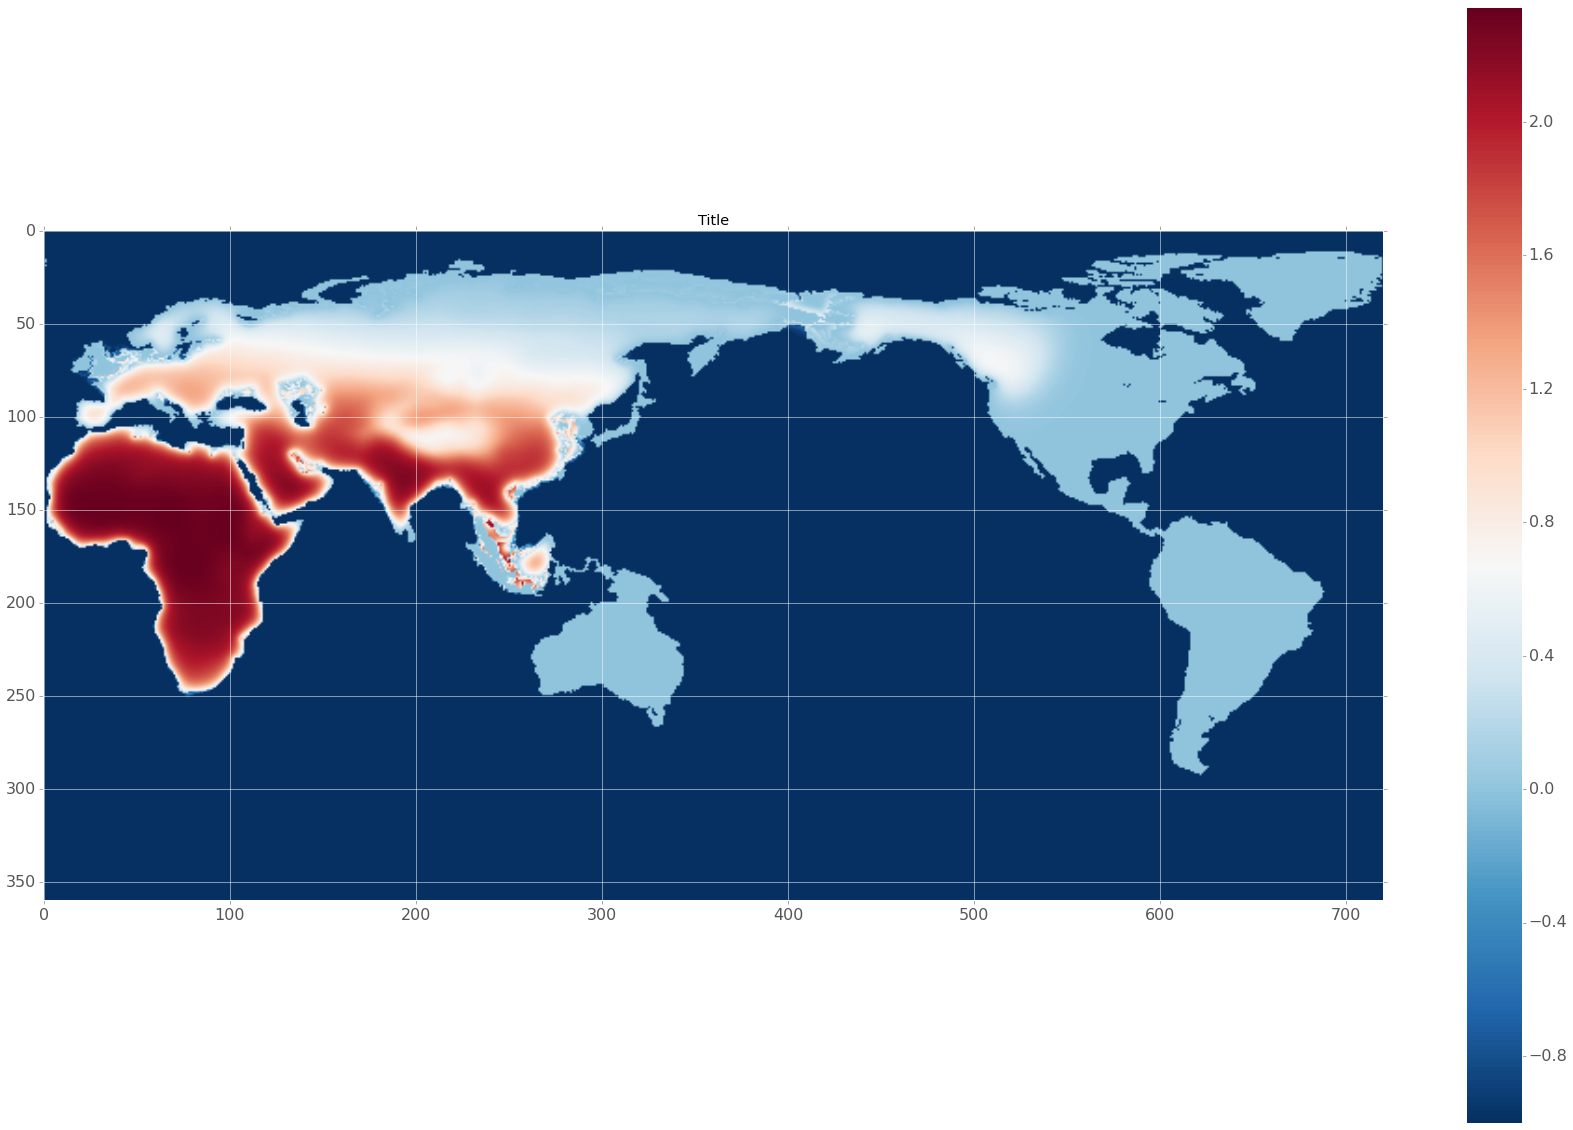

In [77]:
%%px --target 40
%matplotlib inline 
sim.plot()
print(sim.data.u.max())
print(sim.data.u.min())

#Scattering Data

In [78]:
%%px
%%time
sim = LargeSimulation()
#sim = HugeSimulation()
print("====="+sim.data.mapsize+" Simulation Starting=====")
output = False
module = 'C'

#Deciding which booster to use 
if module == 'Fortran':
    import Fmodules as modules

elif module =='C':
    import Cmodules as modules

elif module =='Python':
    import Pymodules as modules 

Ts = sim.data.Ts
Te = sim.data.Te
tsc = sim.data.tsc
h = sim.data.h
kcfl = sim.data.kcfl
#u = sim.data.u      

NS = max(sim.data.NY,sim.data.NX) #find max size 
u0 = zeros(NS)         
u1 = zeros(NS) 
kap0 = zeros(NS)
kaph = zeros(NS)

rows = arange(sim.data.NY)
cols = arange(sim.data.NX)
#Local Rows
#dRow = int(sim.data.NY/mpi.size)
#rowLoc = range(mpi.rank*dRow, (mpi.rank+1)*dRow)
rowCat = split(rows,mpi.size)
rowLoc = rowCat[mpi.rank]
#Local Cols
#dCol = int(sim.data.NX/mpi.size)
#colLoc = range(mpi.rank*dCol, (mpi.rank+1)*dCol)
colCat = split(cols,mpi.size)
colLoc = colCat[mpi.rank]

yp = yppoints() #Interpolation points   

# read the CC map lists and times=tepoch's for each frame: find first
# Search for appropriate NPP maps:
#      from start time Ts (in kya) to end time Te
#loading carrying capacities from namelist
yalist, masks, tepoch = get_cc_list(sim.data.mapsize)

#kstart = 1  
kstart = 0
while tepoch[kstart+1] >= Ts:
    kstart=kstart+1

print('   Start time Ts=%5.1f (kya), NPP frame kstart=%d\n'%(Ts,kstart))

kend = 61 #Leo: Verify this, it's probably 60
while tepoch[kend-1] <= Te: 
    kend=kend-1

print('   End time   Te=%5.1f (kya), NPP frame kend=%d\n'%(Te,kend))

# make sure there are at least 2 maps between Ts and Te
if ((kend-kstart)<1) or ((tepoch[kstart]-tepoch[kend])<(Ts-Te)):
   print('Ts=%e, Te=%e, not space enough: kstart=%d, kend=%d\n'%(Ts,Te,kstart,kend))

#      start and end maps found
kmp = kstart # start counting maps here

#Loading and generating masks 
t_L = tepoch[kmp] 
t_H = tepoch[kmp+1]

#Compute m_LH
#read m_LH
m_LH = readTemplateMap(sim.data.mapsize, masks,kmp)
#Read carrying capacities
#Read w_L, w_H
w_L, w_H = readCC(sim.data.mapsize, yalist, kmp)

kmp = kmp + 1                  # increment map count

# Scan through map, construct segments for X and Y directions 
#Python scanners
nxsegs, xstart_seg, xend_seg = Xscan(m_LH[rowLoc,:])
nysegs, ystart_seg, yend_seg = Yscan(m_LH[:,colLoc])
#Fortran scanners
#nxsegs, xstart_seg, xend_seg = FXscan(m_LH)
#nysegs, ystart_seg, yend_seg = FYscan(m_LH)

#w_H = kapepoch(self.data.w_map,yalist,kmp, self.data.mapsize) # second map
#t_H = tepoch[kmp]

#Computing interpolation weights 
s   = (t_L-Ts+tsc*h)/(t_L-t_H)  # first step interpolation parameter
wt0 = 0.0
# compute interpoated weight to get to step t=h
ks  = floor(100*s)
sd  = 100*s - ks               # residual sd = 100*s mod 1
#wth = yp[0]*(1-sd) + yp[1]*sd  # first interpolant
wth = yp[ks]*(1-sd) + yp[ks+1]*sd  # first interpolant
t   = Ts                       # this is real time in kya

# TGL alternates between 1 and 0 
TGL = True
imID = 0
#TGL = False

# BEGIN main loop
# self.NT = 1

[stdout:40] 
=====Initializing large simulation=====
 INPUT Parameter summary: 
   Number of time steps: NT=1637 
   Plotting interval: NPLT=40 
   Diffusion coeff: Kyb = 2.080000e+02 (in km^2/yr)
   Growth rate: Ryb = 1.670000e-03 (in yr^{-1})
 MAP SIZE: NX=720 (E-W), NY=360 (N-S)
   CELL size: dx=dy = 111.6 (km)=   0.2 (eq. (3) units)
   eq. (3) step size h=5.000000e-02, and CFL number=4.997623e-01 

=====large Simulation Starting=====
   Start time Ts= 50.0 (kya), NPP frame kstart=25

   End time   Te=  1.0 (kya), NPP frame kend=60

CPU times: user 290 ms, sys: 10 ms, total: 300 ms
Wall time: 302 ms
[stdout:41] 
=====Initializing large simulation=====
 INPUT Parameter summary: 
   Number of time steps: NT=1637 
   Plotting interval: NPLT=40 
   Diffusion coeff: Kyb = 2.080000e+02 (in km^2/yr)
   Growth rate: Ryb = 1.670000e-03 (in yr^{-1})
 MAP SIZE: NX=720 (E-W), NY=360 (N-S)
   CELL size: dx=dy = 111.6 (km)=   0.2 (eq. (3) units)
   eq. (3) step size h=5.000000e-02, and CFL number

In [79]:
%%px
%%time
# BEGIN main loop
# sim.NT = 1
#it = 0
start = timer()
for it in range(0,1637):
    #for it in range(0,self.data.NT):
    #%debug 0
    #print('iteration=',it) 
    if TGL: #First choice: half-step1 in X, and step 2 in Y 
        #Split Rows
        if mpi.rank ==0:
            uSplitRows = np.split(u,mpi.size,axis=0)
        else:
            uSplitRows = None

        #Scattering data
        uSplitRows = mpi.scatter(uSplitRows, root=0)    
        u[rowLoc,:]=uSplitRows

        #half-step1 in X
        step1X(rowLoc)

        #Collecting rows
        uCat = mpi.gather(uSplitRows, root=0)
        #Splitting columns
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=0)
            uSplitCols = np.split(u,mpi.size,axis=1)
        else:
            uSplitCols = None

        #Scattering data
        uSplitCols = mpi.scatter(uSplitCols, root=0)
        u[:,colLoc]=uSplitCols

        #step2 in Y-Direction
        stepY(colLoc)

        #Collecting cols
        uCat = mpi.gather(uSplitCols, root=0)

        #Splitting rows 
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=1)
            uSplitRows = np.split(u,mpi.size,axis=0)
        else:
            uSplitRows = None

        #Scattering data
        uSplitRows = mpi.scatter(uSplitRows, root=0)
        u[rowLoc,:]=uSplitRows

        #half-step1 in X-Direction
        step1X(rowLoc)

        #Collecting rows
        uCat = mpi.gather(uSplitRows, root=0)
        #Splitting columns
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=0)

        TGL = False
        
        sim.data.u = u.copy()

    else:
        ##Second choice: half-step1 in Y, and step 2 in X 
        #Splitting columns
        if mpi.rank == 0:
            uSplitCols = np.split(u,mpi.size,axis=1)
        else:
            uSplitCols = None

        #Scattering data
        uSplitCols = mpi.scatter(uSplitCols, root=0)
        u[:,colLoc]=uSplitCols

        #half-step1 in Y
        step1Y(colLoc)

        #Collecting cols
        uCat = mpi.gather(uSplitCols, root=0)

        #Splitting rows 
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=1)
            uSplitRows = np.split(u,mpi.size,axis=0)
        else:
            uSplitRows = None

        #Scattering data
        uSplitRows = mpi.scatter(uSplitRows, root=0)
        u[rowLoc,:]=uSplitRows

        #Step 2 : X direction updates
        stepX(rowLoc)

        #Collecting rows
        uCat = mpi.gather(uSplitRows, root=0)
        #Splitting columns
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=0)
            uSplitCols = np.split(u,mpi.size,axis=1)
        else:
            uSplitCols = None

        #Scattering data
        uSplitCols = mpi.scatter(uSplitCols, root=0)
        u[:,colLoc]=uSplitCols

        # half step1 in Y direction
        step1Y(colLoc)

        #Collecting cols
        uCat = mpi.gather(uSplitCols, root=0)

        #Splitting rows 
        if mpi.rank == 0:
            u = np.concatenate(uCat,axis=1)

        TGL = True

        sim.data.u = u.copy()
        
    #if kmp > kend: 
    #    print 'break hit, leaving loop'
    #    break

    # increment t value, reset weights and maps if necessary
    t = t - tsc*h          # decrement t in kya
    #fprintf(' ordinary step: t_L=%e, t=%e, t_H=%e\n',t_L,t,t_H);
    if t > t_H:              # usual case, maps not exhausted
        wt0 = wth           # shift lower weight down
        s   = (t_L-t)/(t_L-t_H)  # interpolation parameter
        ks  = floor(100*s)
        sd  = 100*s - ks    # residual sd = 100*s mod 1
        wth = yp[ks]*(1-sd) + yp[ks+1]*sd  # first interpolant
    else:                   # reached upper map time 
        kmp = kmp +1                      # increment map count
        if kmp <= kend:               # kend is the last map
            #Compute m_LH
            #read m_LH
            m_LH = readTemplateMap(sim.data.mapsize, masks,kmp-1)
            #Read carrying capacities
            #Read w_L, w_H
            w_L, w_H = readCC(sim.data.mapsize, yalist, kmp-1)

            #m_L = m_H
            #w_L = w_H                 # set lower map to prev. upper
            t_L = t_H                 # set lower time to prev. upper
            t_H = tepoch[kmp]         # time frame of new map

            nxsegs, xstart_seg, xend_seg = Xscan(m_LH[rowLoc,:])
            nysegs, ystart_seg, yend_seg = Yscan(m_LH[:,colLoc])
            #nxsegs, xstart_seg, xend_seg = FXscan(m_LH)
            #nysegs, ystart_seg, yend_seg = FYscan(m_LH)

            wt0 = 0
            s   = (t_L - t)/(t_L-t_H)  # interpolation parameter
            ks  = floor(100*s)
            sd  = 100*s - ks                    # mod1 interpolation 
            wth = yp[ks]*(1-sd) + yp[ks+1]*sd  # first interpolant

    ##Monitoring data
    if (mod(it,sim.data.NPLT)==0)or(it==sim.data.NT):
        if t < 10:
            tstr = '   %4.2f'%t
            print(tstr)
            if output:
                store(imID, sim.data)

        else:
            tstr = '   %4.1f'%t
            print(tstr)
            if output:
                storeData(imID, sim.data)

end = timer()
print("====="+sim.data.mapsize+" simulation completed=====")
print('   Main Loop Time:', end-start)

[stdout:40] 
   50.0
   48.8
   47.6
   46.4
   45.2
   44.0
   42.8
   41.6
   40.4
   39.2
   38.0
   36.8
   35.6
   34.4
   33.2
   32.0
   30.8
   29.6
   28.4
   27.2
   26.0
   24.8
   23.6
   22.4
   21.2
   20.0
   18.8
   17.6
   16.4
   15.2
   14.0
   12.8
   11.6
   10.4
   9.25
   8.05
   6.86
   5.66
   4.46
   3.26
   2.07
=====large simulation completed=====
   Main Loop Time: 79.96097231190652
CPU times: user 1min 19s, sys: 70 ms, total: 1min 19s
Wall time: 1min 19s
[stdout:41] 
   50.0
   48.8
   47.6
   46.4
   45.2
   44.0
   42.8
   41.6
   40.4
   39.2
   38.0
   36.8
   35.6
   34.4
   33.2
   32.0
   30.8
   29.6
   28.4
   27.2
   26.0
   24.8
   23.6
   22.4
   21.2
   20.0
   18.8
   17.6
   16.4
   15.2
   14.0
   12.8
   11.6
   10.4
   9.25
   8.05
   6.86
   5.66
   4.46
   3.26
   2.07
=====large simulation completed=====
   Main Loop Time: 79.96019166195765
CPU times: user 1min 19s, sys: 100 ms, total: 1min 19s
Wall time: 1min 19s
[stdout:42] 
   50.0


=====Plotting Results=====
0.942680265462
0.0


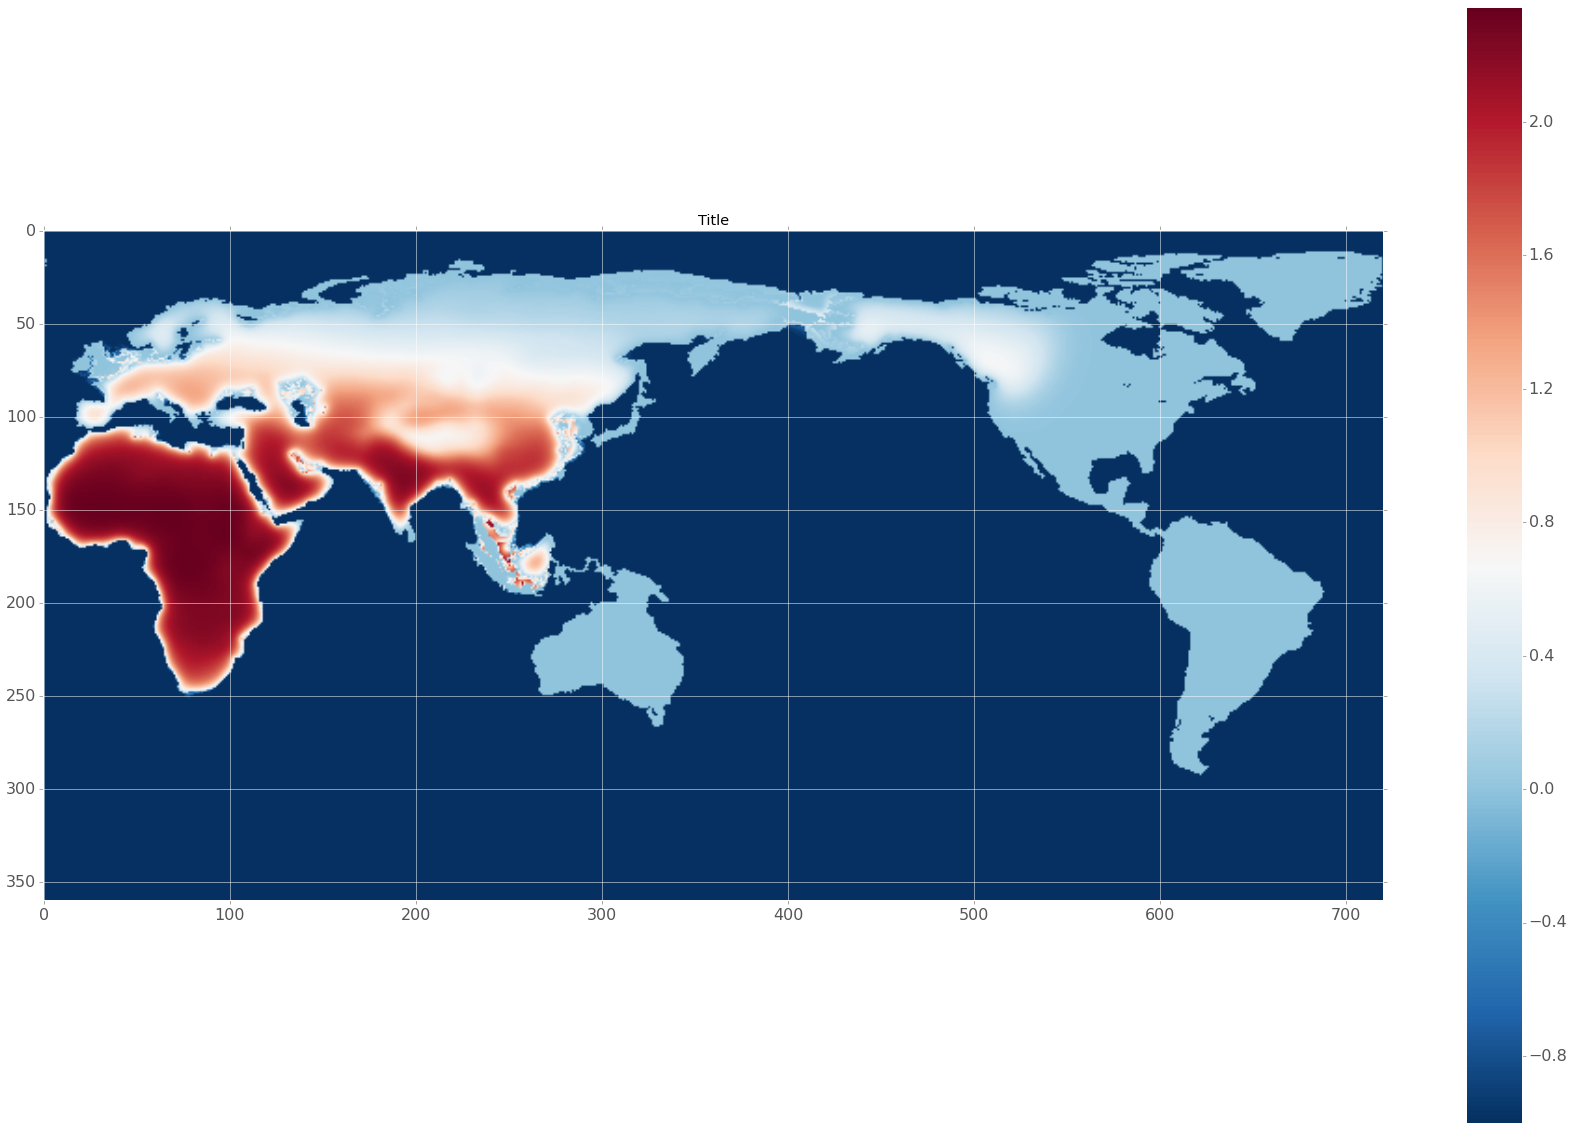

In [67]:
%%px --target 0
%matplotlib inline 
sim.plot()
print(sim.data.u.max())
print(sim.data.u.min())